# <font color='green'>Reproducing repetition and Shor code simulations using `stim`</font>

So far, you have learned the structure of bit-flip and phase-flip repetition codes, and put them together in Shor's 9-qubit code to protect against both kinds of errors. As you will see later, the lessons learned from these codes will extend into our discussion of surface codes.

To build and simulate the behavior of each of these error-correcting codes, you had to pay attention to:
- The structure of the encoding and decoding circuits,
- The stabilizers in use, and how the syndrome measurement circuits can be implemented,
- How noise can be injected and used to detect when logical errors occur, and
- The runtime of the simulations, and techniques for speeding them up by sampling efficiently.

State-of-the-art tools of the field like `stim` and `Deltakit` do all of the above work for you, and make it easy to produce the plots that we have seen so far. This chapter reproduces the results from bit-flip and phase-flip repetition codes, as well as the Shor code, in very few lines.

In [1]:
import numpy as np
import stim
import pymatching as pm
import matplotlib.pyplot as plotter
from tqdm import tqdm
from phase_flip_rep_codes import plot_logical_error_probabilities, get_logical_error_probability_analytical

## <font color='blue'>Introduction to `stim`</font>

The library `stim` is able to generate the repetition code circuits that we have previously seen in one line, including insertion of noise. Here is an example that shows a distance-3 $Z$-type repetition code, where a specific type of depolarizing noise is inserted just before a round of syndrome measurements. Depolarizing noise is commonly used when exploring the error-correction performance of superconducting qubits.

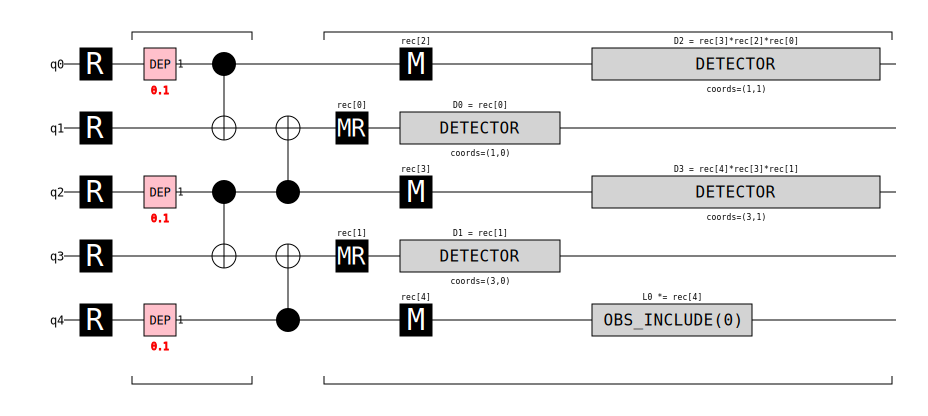

In [2]:
distance = 3
error_probability = 0.1
c = stim.Circuit.generated("repetition_code:memory", distance=distance, rounds=1,
                           before_round_data_depolarization=error_probability)
display(c.diagram('timeline-svg'))

Note the resets at the beginning to initialize all qubits, including the `distance` data qubits (`q0`, `q2` and `q4`), and `distance - 1` ancilla qubits (`q1` and `q3`). Also note the measurements after the pairwise parity checks tagged `rec[0]` and `rec[1]`.

One of the key features of `stim` is the use of detectors. There is one detector per check in each time slice, and these detectors compare that check's outcome to the one before it. The very first detectors anchor the first check to the known start state after resets -- without this, an error that happens before the first round (eg during reset) would not be detected. The very last detectors anchor the last checks to the end of the circuit -- without this, a readout glitch in the last round would not be detected. The coordinates under the detectors are `(x,t)` pairs, indicating their space-time locations.

Altogether, a repetition code with `distance` data qubits running `R` rounds of syndrome checks would have `(R - 1)` $\times$ `(distance-1)` between-round detectors, and then two more `(distance-1)` detectors anchoring to the start and end, for a total of  `(R + 1)` $\times$ `(distance-1)` detectors.

`stim` creates a rich detector error model that captures the effect of error occuring at the various locations within the circuit, and assigns a weight to the probability of each of these errors flipping any of the detectors. This weighting can be used in a matching decoder to predict where errors might have occurred. `stim` also notes the effect of errors within the circuit on the observables tied to the circuit ($Z_0Z_1Z_2$ in a distance-3 repetition code, for example), and the mismatch between the effect of an error on the observable and the prediction of a decoder can be used to determine logical errors.

## <font color='blue'>Simulating bit-flip and phase-flip repetition codes using `stim`</font>

As in previous chapters, we will define a function `get_logical_error_probability_for_rep_code` which returns the logical error probability for a given configuration of `distance` and `error_probability` by sampling a number of shots. Then, we will repeatedly invoke this function for various parameters to generate the plots as we have previously done.

In [3]:
def get_logical_error_probability_for_rep_code(distance, p, basis="Z", rounds=1, n_shots=50_000):

    if distance == 1:
        return p
    
    circuit = stim.Circuit.generated(
        "repetition_code:memory",
        rounds=rounds,
        distance=distance,
        before_round_data_depolarization = 1.5*p, # note the factor of 1.5 here, discussion in footnote below
    )
    if basis == "X":
        # Switch basis from Z to X by applying global Hadamards
        # eg: H 0 1 2 3 4 for distance 5
        H_on_all_data_qubits = "H " + " ".join(str(qubit_index) for qubit_index in range(distance))
        circuit =   stim.Circuit(H_on_all_data_qubits) + \
                    circuit + \
                    stim.Circuit(H_on_all_data_qubits)
    
    # first, sample the circuit itself
    # we sample the circuit by creating a fast sampler that produces both detection events
    # and observable flips of the stabilizers without needing full statevector simulation
    # note that a detector is a parity check as we have been doing so far using ancilla qubits
    # there are (d-1) * (R+1) detectors for distance d rep codes with R rounds corresponding to the pairwise ZZ/XX checks
    ds = circuit.compile_detector_sampler()
    # D = detector flips, shape (n_shots, n_detectors)
    # L = logical observable flips, shape (n_shots, n_observables)
    D, L = ds.sample(n_shots, separate_observables=True)

    # next, generate a decoder from the circuit's detector error model and use it to decode
    # the DEM maps possible error locations -> which syndrome parity checks (detectors) flip
    # and captures the probabilities of all the possible error locations (eg an X on qubit 1 after this specific gate)
    # leading to a flip of one of the detectors and logical observables
    dem = circuit.detector_error_model(decompose_errors=True)
    # the decoder is MWPM as we have seen so far, and the weights of the MWPM decoder come from the DEM's error probabilities
    m = pm.Matching.from_detector_error_model(dem)
    # then, use the decoder to predict when logical errors have occurred
    pred = m.decode_batch(D)

    # pred contains the error location predictions from the decoded syndrome measurements
    # L contains the actual observable flips
    # when the two mismatch, a logical error will occur
    total_logical_error_count = sum(pred[:, 0] != L[:, 0])
    
    return total_logical_error_count / n_shots

In [4]:
def get_logical_error_probability_stim(distances, ps, basis="Z", rounds=1, n_shots=50_000):
    p_Ls = np.zeros((len(distances), len(ps)))
    for i, d in enumerate(distances):
        print(f"Simulating distance-{d} repetition code circuits")
        for j, p in tqdm(enumerate(ps)):
            p_Ls[i, j] = get_logical_error_probability_for_rep_code(d, p, basis=basis, rounds=rounds, n_shots=n_shots)
    return p_Ls

Now, we can make our first physical error probability vs logical error probability study using `stim` using the above functions.

### <font color='red'>Bit-flip repetition codes</font>

In [5]:
ps = np.logspace(-4, -1, 20)
distances = [3, 5, 7, 9]
repcode_type = 'X'
n_shots = 10_000_000

p_Ls = get_logical_error_probability_stim(distances, ps, basis=repcode_type, rounds=1, n_shots=n_shots)
analytical_p_Ls = get_logical_error_probability_analytical(distances, ps)

Simulating distance-3 repetition code circuits


20it [00:15,  1.27it/s]


Simulating distance-5 repetition code circuits


20it [00:18,  1.07it/s]


Simulating distance-7 repetition code circuits


20it [00:21,  1.09s/it]


Simulating distance-9 repetition code circuits


20it [00:24,  1.23s/it]


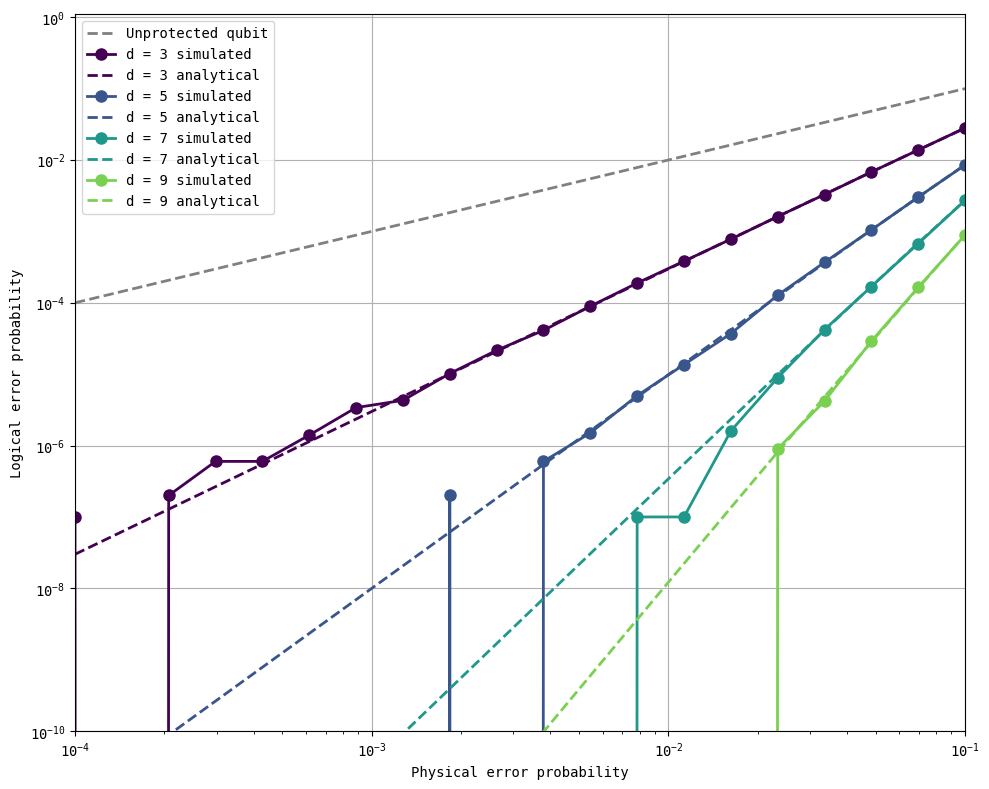

In [6]:
plot_logical_error_probabilities(distances, ps, p_Ls, analytical_p_Ls)

As you can see above, `stim` can sample 10 million shots in about 1 second at distance 3 with minimal use of the tricks in the previous chapter. To speed up these simulations even further by spreading the work across multiple CPU cores, another popular tool called `sinter` can be used.

### <font color='red'>Phase-flip repetition codes</font>

In [7]:
ps = np.logspace(-4, -1, 20)
distances = [3, 5, 7, 9]
repcode_type = 'Z'
n_shots = 10_000_000

p_Ls = get_logical_error_probability_stim(distances, ps, basis=repcode_type, rounds=1, n_shots=n_shots)
analytical_p_Ls = get_logical_error_probability_analytical(distances, ps)

Simulating distance-3 repetition code circuits


20it [00:15,  1.33it/s]


Simulating distance-5 repetition code circuits


20it [00:17,  1.12it/s]


Simulating distance-7 repetition code circuits


20it [00:20,  1.04s/it]


Simulating distance-9 repetition code circuits


20it [00:23,  1.18s/it]


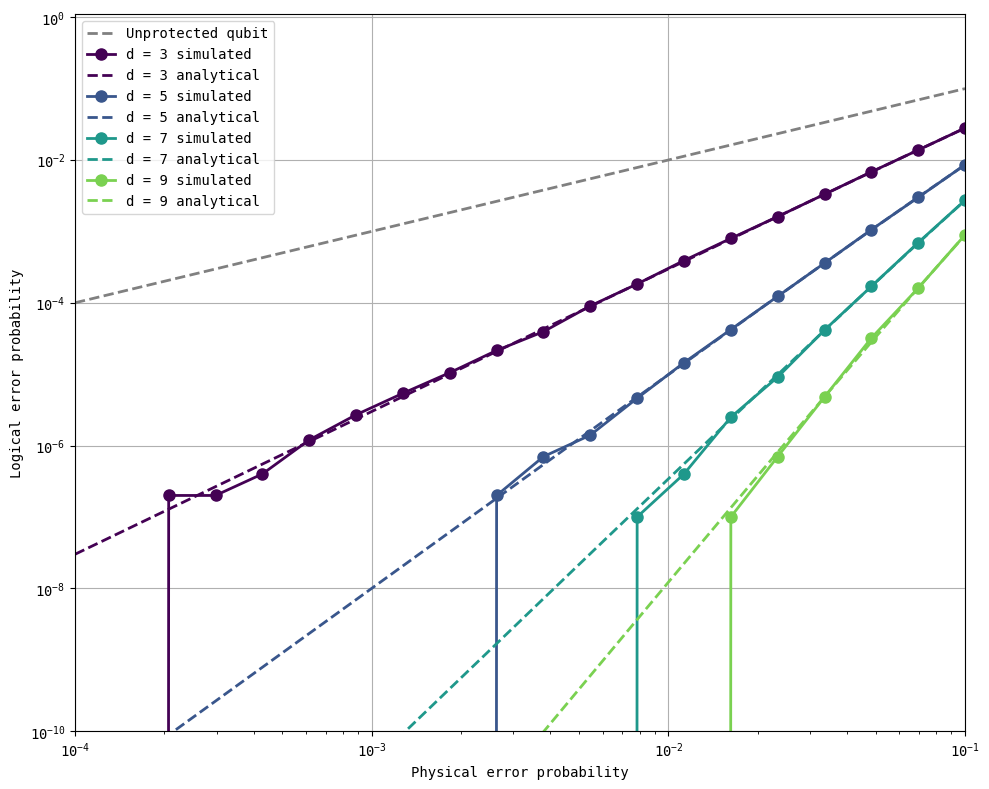

In [8]:
plot_logical_error_probabilities(distances, ps, p_Ls, analytical_p_Ls)

## <font color='blue'>Simulating the 9-qubit Shor code using `stim`</font>

Since `stim` only provides circuit builders for repetition codes and surface codes, we will demonstrate how to define our own circuits below by building the Shor code.

In [9]:
def build_shor_code_circuit_stim(p, error_gate='X'):

    lines = []
    # prepare 3 GHZ blocks
    lines.append("R 0 1 2 3 4 5 6 7 8")
    lines.append("H 0 3 6")
    lines.append("CNOT 0 1 0 2 3 4 3 5 6 7 6 8")

    # insert error gates
    if error_gate == 'X':
        lines.append(f"X_ERROR({p}) 0 1 2 3 4 5 6 7 8")
    else:
        lines.append(f"Z_ERROR({p}) 0 1 2 3 4 5 6 7 8")

    # syndrome checks and associated detectors
    if error_gate == 'X':
        # X noise anti-commutes with ZZ checks within blocks
        for zz in ["Z0*Z1", "Z1*Z2", "Z3*Z4", "Z4*Z5", "Z6*Z7", "Z7*Z8"]:
            lines.append(f"MPP {zz}")
            lines.append("DETECTOR rec[-1]")
        # XX checks across blocks
        for xx in ["X0*X1*X2*X3*X4*X5", "X3*X4*X5*X6*X7*X8"]:
            lines.append(f"MPP {xx}")
            lines.append("DETECTOR rec[-1]")
        # Logical Z_L at the end (to be used as observable)
        lines.append("MPP Z0*Z3*Z6")
        lines.append("OBSERVABLE_INCLUDE(0) rec[-1]")
    else: # error gate is Z
        # Z noise anti-commutes with XX checks across blocks
        for xx in ["X0*X1*X2*X3*X4*X5", "X3*X4*X5*X6*X7*X8"]:
            lines.append(f"MPP {xx}")
            lines.append("DETECTOR rec[-1]")
        # ZZ checks within blocks
        for zz in ["Z0*Z1", "Z1*Z2", "Z3*Z4", "Z4*Z5", "Z6*Z7", "Z7*Z8"]:
            lines.append(f"MPP {zz}")
            lines.append("DETECTOR rec[-1]")
        # Logical X_L at the end (to be used as observable)
        lines.append("MPP X0*X1*X2*X3*X4*X5*X6*X7*X8")
        lines.append("OBSERVABLE_INCLUDE(0) rec[-1]")

    return stim.Circuit("\n".join(lines))

def get_logical_error_probability_for_shor_code(p, n_shots=50_000, error_gate='X', verbose = False):
    circuit = build_shor_code_circuit_stim(p, error_gate=error_gate)
    if verbose:
        display(circuit.diagram('timeline-svg'))

    # same workflow as in rep codes: 
    # sample shots from the circuit to get detector and logical observable flips
    # create a DEM from the circuit to use for the decoder
    # determine if the decoder can use the detector flips to predict observable flips
    ds = circuit.compile_detector_sampler()
    D, L = ds.sample(n_shots, separate_observables=True)
    dem = circuit.detector_error_model(decompose_errors=True)
    m = pm.Matching.from_detector_error_model(dem)
    pred = m.decode_batch(D)
    total_logical_error_count = sum(pred[:, 0] != L[:, 0])
    return total_logical_error_count / n_shots

def get_logical_error_probability_stim_shor(ps, n_shots=50_000, error_gate='X'):
    p_Ls = np.zeros((1, len(ps)))
    for j, p in enumerate(ps):
        if j == 0:
            p_Ls[0, j] = get_logical_error_probability_for_shor_code(p, n_shots=n_shots, error_gate=error_gate, verbose = True)
        else:
            p_Ls[0, j] = get_logical_error_probability_for_shor_code(p, n_shots=n_shots, error_gate=error_gate, verbose = False)            
    return p_Ls

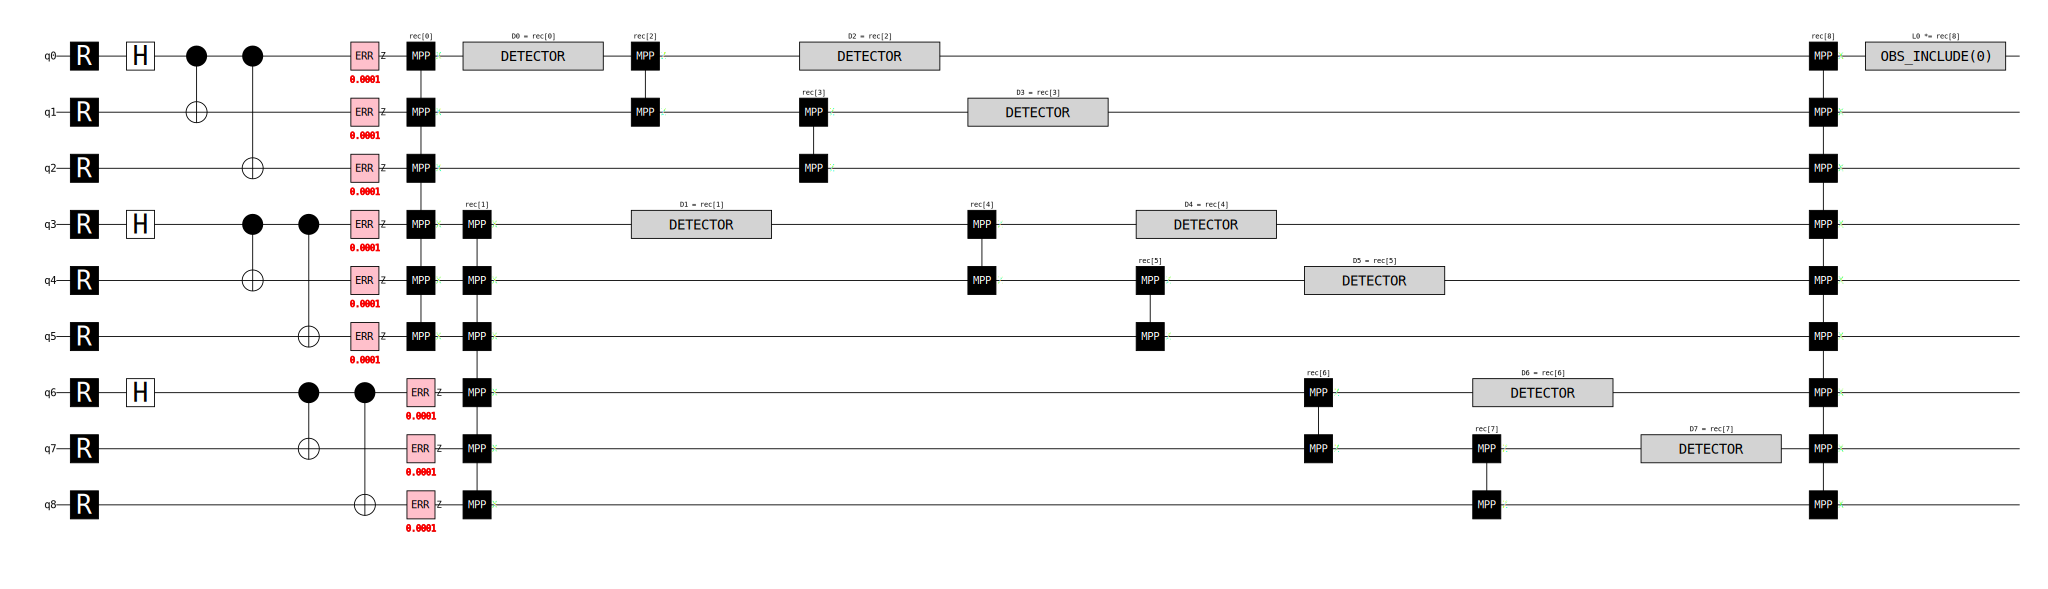

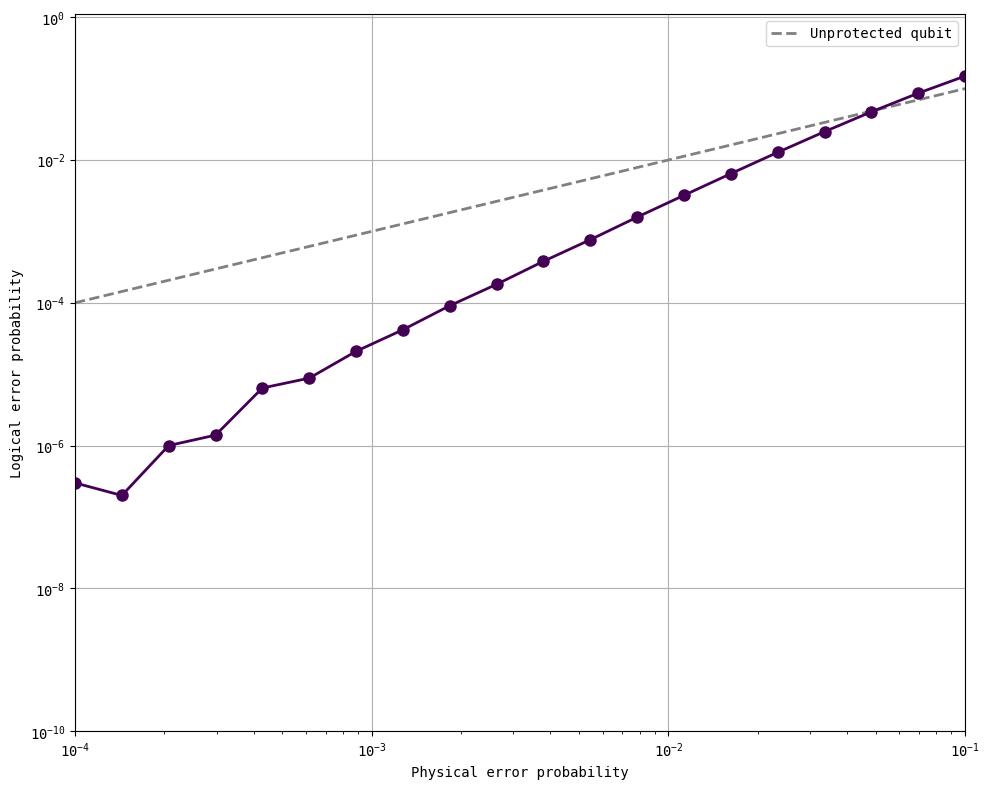

In [10]:
ps = np.logspace(-4, -1, 20)
n_shots = 10_000_000

p_Ls = get_logical_error_probability_stim_shor(ps = ps, n_shots = n_shots, error_gate = 'Z')
plot_logical_error_probabilities(None, ps, p_Ls, None)

## <font color='blue'>Further reading</font>

In this tutorial, you saw how `stim` can be used to reproduce the simulation results from the previous chapters. For further reading about `stim`, consider visiting [the Github repository here](https://github.com/quantumlib/stim).

**Footnote**: the astute reader may have noticed the factor of 1.5 that was inserted in the repetition code example (`before_round_data_depolarization = 1.5*p`). Until this chapter, $p$ has signified the probability that an $X$ or $Z$ error is applied. The noise model used by `stim` with the setting `before_round_data_depolarization=p` applies $X$, $Y$ _and_ $Z$ errors, each with probability $p/3$. In a $Z$-type repetition code memory experiment where we are trying to protect against bit-flip noise, both $X$ and $Y$ can cause bit-flips, but $Z$ does not. So the effective bit-flip rate is $p_{\text{flip}} = 2/3$. To set the effective bit-flip rate to $p$, we multiply by a factor of $3/2=1.5$ as used in the example above. The same argument holds for $X$-type repetition codes.